## **Информация о задании**
**Работу выполнила Дзюба Мария, 317 группа**

**ВАЖНО Если в конце файла нет большого количества изображений, то есть два варианта их просмотра: сделать ноутбук trusted (проверенно, работает), либо открыть ноутбук по ссылке** [ССЫЛКА НА КОЛАБ](https://colab.research.google.com/drive/1VeqJnlo21pNOxQfiimlFwtXLgRZSprr8?usp=sharing) 


**Постановка задачи:** В данном задании предлагалось поэксперементировать с интерпретацией нейронных сетей. В работе рассмотренны три архитектуры vgg19,alexnet и densenet152. Все модели - предобученны. 

Ячейки с кодом алгоритмов построение saliency map, occlusion sensitivity и grad-cam размещены в отдельном разделе, чтобы не занимать много места в самом ноутбуке. 

Все эксперименты приведены в самом последнем разделе данного ноутбука. Показано применение всех указанных выше алгоритмов на указанных моделях. 

In [ ]:
pip install flashtorch

In [ ]:
import warnings
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import torch
from PIL import Image
from collections import Sequence
from tqdm import tqdm
from torch.nn import functional as F
from cv2 import cv2
import os.path as osp
import numpy as np
import matplotlib.cm as cm
from flashtorch.utils.imagenet import ImageNetIndex
from torchvision import transforms

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


## **Код всех алгоритмов и дополнительных функций**

### **Код для построения saliency map**

Основа решения взята из кода opensource библиотеки flashtorch. 

[Препроцессинг](https://github.com/MisaOgura/flashtorch/blob/master/flashtorch/utils/__init__.py)

[Backpropagation](https://github.com/MisaOgura/flashtorch/blob/master/flashtorch/saliency/backprop.py)

**◾ Препроцессинг изображений для подачи в сеть. Подготовка изображений для вывода (денормализация)**

In [4]:
transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

# Функция для денормализации изображения (для корректного сохранения и отображения)
def denormalize(tensor):

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]


    denormalized = tensor.clone()

    denormalized[0][0,:,:] = denormalized[0][0,:,:]*stds[0] + means[0]
    denormalized[0][1,:,:] = denormalized[0][1,:,:]*stds[1] + means[1]
    denormalized[0][2,:,:] = denormalized[0][2,:,:]*stds[2] + means[2]



    return denormalized
    

def standardize_and_clip(tensor, min_value=0.0, max_value=1.0,
                         saturation=0.1, brightness=0.5):

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()

    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(saturation)
    clipped = standardized.add(brightness).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()


**◾ Класс для осуществления backpropagation**

In [6]:
#Класс для осуществления backpropagation

class Backprop:
  def __init__(self, model):
    self.model = model
    self.model.eval()
    self.gradients = None
    self._register_conv_hook()

  def calculate_gradients(self, input_, target_class=None, take_max=False, use_gpu=False):

    if torch.cuda.is_available() and use_gpu:
        self.model = self.model.to('cuda')
        input_ = input_.to('cuda')

    self.model.zero_grad()
    self.gradients = torch.zeros(input_.shape)

    output = self.model(input_)

    if len(output.shape) == 1:
            target = None
    else:
        _, top_class = output.topk(1, dim=1)

        target = torch.FloatTensor(1, output.shape[-1]).zero_()

        if torch.cuda.is_available() and use_gpu:
            target = target.to('cuda')

        target[0][top_class] = 1


    output.backward(gradient=target)
    gradients = self.gradients.detach().cpu()[0]

    if take_max:
        gradients = gradients.max(dim=0, keepdim=True)[0]

    return gradients



  def _register_conv_hook(self):
    def _record_gradients(module, grad_in, grad_out):
      if self.gradients.shape == grad_in[0].shape:
          self.gradients = grad_in[0]

    for _, module in self.model.named_modules():
        if isinstance(module, nn.modules.conv.Conv2d):
            module.register_backward_hook(_record_gradients)
            break

  def _register_relu_hooks(self):
      def _record_output(module, input_, output):
          self.relu_outputs.append(output)

      def _clip_gradients(module, grad_in, grad_out):
          relu_output = self.relu_outputs.pop()
          clippled_grad_out = grad_out[0].clamp(0.0)

          return (clippled_grad_out.mul(relu_output),)

      for _, module in self.model.named_modules():
          if isinstance(module, nn.ReLU):
              module.register_forward_hook(_record_output)
              module.register_backward_hook(_clip_gradients)


# Код для визуализации saliency map        
def visualize(input_, gradients, max_gradients, target_class=None, guided=False, use_gpu=False,
                figsize=(16, 4), cmap='viridis', alpha=.5,
                return_output=False, path=None, model_name="", foto_name=""):

    subplots = [
        ('Input image',
          [(format_for_plotting(denormalize(input_)), None, None)]),
        ('Gradients across RGB channels',
          [(format_for_plotting(standardize_and_clip(gradients)), None, None)]),
        ('Max gradients',
          [(format_for_plotting(standardize_and_clip(max_gradients)), cmap, None)]),
        ('Overlay',
          [(format_for_plotting(denormalize(input_)), None, None), 
           (format_for_plotting(standardize_and_clip(max_gradients)),
            cmap,
            alpha)])
    ]

    fig = plt.figure(figsize=figsize)
    plt.suptitle(model_name, fontsize = 20)
    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, len(subplots), i + 1)
        ax.set_axis_off()
        ax.set_title(title)
        
        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)
            if i == 3:
              filename=osp.join(path, f"{model_name}-{foto_name}-saliencymap.png")
              plt.savefig(filename)

### **Код для построения occlusion sensitivity**




Код основан на алгоритме, приведенном [здесь](https://github.com/kazuto1011/grad-cam-pytorch/blob/master/grad_cam.py).



In [9]:
def occlusion_sensitivity(model, images, ids, mean=None, patch=35, stride=1, n_batches=128):
    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    baseline = model(images).detach().gather(1, ids)
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps


**◾ Создание и сохранение результатов occlusion sensitivity**

In [10]:
def create_occlusion_sensitivity(device, model, img_path, model_name):
    device = 'cuda'

    model = model

    model = torch.nn.DataParallel(model)
    model.to(device)
    model.eval()


    raw_image = cv2.imread(img_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())

    print("Occlusion Sensitivity:")

    patche_sizes = [10, 25, 35, 45, 90]

    image = image.reshape((1,3,224,224))
    logits = model(image)
    probs = F.softmax(logits, dim=1)
    probs, ids = probs.sort(dim=1, descending=True)

    output_dir = '/content/drive/MyDrive/results_sensitivity'

    for i in range(3):
        for p in patche_sizes:
            print("Patch:", p)
            sensitivity = occlusion_sensitivity(
                model, image, ids[:, [i]], patch=p)
            
            for j in range(len(image)):
                    print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                    save_sensitivity(
                        filename=osp.join(
                            output_dir,
                            "{}-{}-sensitivity-{}-{}.png".format(
                                j, model_name, p, classes[ids[j, i]]
                            ),
                        ),
                        maps=sensitivity[j],
                    )

In [11]:
def save_sensitivity(filename, maps):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(filename, maps)

### **Код для построения GRAD-CAM**

Идея решения и части кода были позаимствованны [здесь](https://colab.research.google.com/github/csc413-uoft/2021/blob/master/assets/tutorials/tut04_cnn.ipynb#scrollTo=O1yFP-dMNXmC) и [здесь](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82)



In [13]:
class CamExtractor():
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):

        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)
            ###
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x 
        return conv_output, x

    def forward_pass(self, x):

        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  

        x = self.model.classifier(x)
        return conv_output, x


class GradCam():

    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):

        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())

        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()

        model_output.backward(gradient=one_hot_output, retain_graph=True)

        guided_gradients = self.extractor.gradients.data.numpy()[0]

        target = conv_output.data.numpy()[0]

        weights = np.mean(guided_gradients, axis=(1, 2))  

        cam = np.ones(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam = np.uint8(cam * 255)  
        #cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       #input_image.shape[3]), Image.ANTIALIAS))

        return cam

In [14]:
# Нам пришлось создать отдельный класс DenseNet из-за отличной от других рассматриваемых моделей вложенной структуры. 
# Это было необходимо для правильного выявления выходов конкретного слоя.

class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        self.densenet = models.densenet201(pretrained=True)
        
        self.features_conv = self.densenet.features
        
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        self.classifier = self.densenet.classifier
        
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        h = x.register_hook(self.activations_hook)
        x = self.global_avg_pool(x)
        x = x.view((1, 1920))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

## **Применение алгоритмов к различным моделям**

**◾ Данный блок показывает работу каждой из моделей на тестовых данных. Выходы ячеек были стерты, так как проводилось несколько эксперементов с каждой ячейкой кода. Полученные результаты отражены в следующем блоке.**

In [15]:
# classes - список, состоящий из id класса в Imagenet и его расшифровки (например 207 - Retriver)
classes = []
with open("/content/synset_words.txt") as lines:
    for line in lines:
        line = line.strip().split(" ", 1)[1]
        line = line.split(", ", 1)[0].replace(" ", "_")
        classes.append(line)

### **AlexNet**

**◾ Создание и сохранение примеров**

In [ ]:
img_path = "/content/retriver.jpg"
img = Image.open(img_path).convert('RGB')

inp = transform(img).unsqueeze(0)
inp.requires_grad = True

model = models.alexnet(pretrained=True)
model.eval()
target_class =207 # imagenet['miniature poodle']
backprop = Backprop(model)
gradients = backprop.calculate_gradients(inp,  guided=False, target_class=target_class)
max_gradients = backprop.calculate_gradients(inp,  take_max=True, guided=False, target_class=target_class)

In [ ]:
visualize(inp, gradients, max_gradients, path='/content/drive/MyDrive/results_saliency', model_name="AlexNet", foto_name="retriver")

In [ ]:
# Создание occlusion sensitivity
create_occlusion_sensitivity('cuda', model=models.alexnet(pretrained=True), img_path = "/content/church.jpg", model_name = "Alexnet")

In [ ]:
# Создание grad-cam с разным размером патчей
img_path = "/content/french_dog.jfif"
img = Image.open(img_path).convert('RGB')

raw_img = img.copy()
raw_img = transforms.Resize(256)(raw_img)
raw_img = transforms.CenterCrop(224)(raw_img)
raw_img = [raw_img]

inp = transform(img).unsqueeze(0)
inp.requires_grad = True
device = 'cpu'
inp = inp.to(device)

output_dir = '/content/drive/MyDrive/results_gradcam'

model_name = "AlexNet"

for t in range(1, 12, 1):
  target_layer = t

  model = models.alexnet(pretrained=True)
  gcv2 = GradCam(model, target_layer=t)
  target_class = 245
  cam = gcv2.generate_cam(inp, target_class)


  heatmap = cv2.resize(cam, (np.asarray(raw_img[0]).shape[1], np.asarray(raw_img[0]).shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  plt.imshow(heatmap)
  img =raw_img[0] + (0.4*heatmap).astype(int)
  img = img.astype(int)
  filename=osp.join(output_dir,"{}-gradcam-{}-{}.png".format( model_name, target_layer, str(classes[target_class])))
  plt.axis('off')

  plt.imshow(img)
  plt.box(False)
  plt.savefig(filename, framon=False)


### **vgg19**

In [ ]:
img_path = "/content/retriver.jpg"
img = Image.open(img_path).convert('RGB')

inp = transform(img).unsqueeze(0)
inp.requires_grad = True


model = models.vgg19(pretrained=True)
backprop = Backprop(model)


imagenet = ImageNetIndex()
target_class =207 # imagenet['miniature poodle']
gradients = backprop.calculate_gradients(inp,  guided=False, target_class=target_class)
max_gradients = backprop.calculate_gradients(inp,  take_max = True, guided=False, target_class=target_class)
visualize(inp, gradients, max_gradients, path='/content/drive/MyDrive/results_saliency', model_name="vgg19", foto_name="retriver" )

In [ ]:
# Создание occlusion sensitivity
create_occlusion_sensitivity('cuda', model=models.vgg19(pretrained=True), img_path = "/content/kot_pes.jpg", model_name = "vgg19")

In [ ]:
# Создание gradcam с разными размерами патчей
img_path = "/content/kot_pes.jpg"
img = Image.open(img_path).convert('RGB')

raw_img = img.copy()
raw_img = transforms.Resize(256)(raw_img)
raw_img = transforms.CenterCrop(224)(raw_img)
raw_img = [raw_img]

inp = transform(img).unsqueeze(0)
inp.requires_grad = True
device = 'cpu'
inp = inp.to(device)

output_dir = '/content/drive/MyDrive/results_gradcam'

model_name = "VGG19"
target_layer=36
model = models.vgg19(pretrained=True)

for t in [36]:
  target_layer=t

  gcv2 = GradCam(model, target_layer=t)
  target_class = 245
  cam = gcv2.generate_cam(inp, target_class)


  heatmap = cv2.resize(cam, (np.asarray(raw_img[0]).shape[1], np.asarray(raw_img[0]).shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #heatmap = heatmap[:,:,[2,1,0]]
  img =raw_img[0] + (0.4*heatmap).astype(int)
  img = img.astype(int)
  filename=osp.join(output_dir,"{}-gradcam-{}-{}.png".format( model_name, target_layer, str(classes[target_class])))
  plt.axis('off')

  plt.imshow(img)
  plt.box(False)
  plt.savefig(filename, framon=False)

### **densenet201**

In [ ]:
img_path = "/content/retriver.jpg"
img = Image.open(img_path).convert('RGB')

raw_img = img.copy()
raw_img = transforms.Resize(256)(raw_img)
raw_img = transforms.CenterCrop(224)(raw_img)
raw_img = [raw_img]

inp = transform(img).unsqueeze(0)
inp.requires_grad = True
device = 'cpu'
inp = inp.to(device)

inp = transform(img).unsqueeze(0)
inp.requires_grad = True


model = models.densenet201(pretrained=True)
backprop = Backprop(model)

imagenet = ImageNetIndex()
target_class = 207 # imagenet['miniature poodle']
gradients = backprop.calculate_gradients(inp,  guided=False, target_class=target_class)
max_gradients = backprop.calculate_gradients(inp,  take_max = True, guided=False, target_class=target_class)
visualize(inp, gradients, max_gradients, path='/content/drive/MyDrive/results_saliency', model_name="Densenet201", foto_name="retriver")

In [ ]:
# Создание occlusion sensitivity
create_occlusion_sensitivity('cuda', model=models.densenet201(pretrained=True), img_path = "/content/retriver.jpg", model_name = "DenceNet")

In [ ]:
# Создание gradcam с разным размером патчей 
dense = DenseNet()
dense.eval()
output_dir = '/content/drive/MyDrive/results_gradcam'

img_path = "/content/retriver.jpg"
img = Image.open(img_path).convert('RGB')
 
model_name = "DenseNet"
raw_img = img.copy()
raw_img = transforms.Resize(256)(raw_img)
raw_img = transforms.CenterCrop(224)(raw_img)
raw_img = [raw_img]

inp = transform(img).unsqueeze(0)
inp.requires_grad = True
device = 'cpu'
inp = inp.to(device)


inp = transform(img).unsqueeze(0)
inp.requires_grad = True

pred = dense(inp)
pred[:, 386].backward()
gradients = dense.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = dense.get_activations(inp).detach()

target_class = 207
heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.asarray(heatmap)

cam = np.maximum(heatmap, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
cam = np.uint8(cam * 255)  
plt.imshow(cam)


heatmap = cv2.resize(cam, (np.asarray(raw_img[0]).shape[1], np.asarray(raw_img[0]).shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(heatmap)
img =raw_img[0] + (0.4*heatmap).astype(int)

img = img.astype(int)

filename=osp.join(output_dir,"{}-gradcam-{}.png".format( model_name,  str(classes[target_class])))
plt.axis('off')

plt.imshow(img)
plt.box(False)
plt.savefig(filename, framon=False)


## **Иллюстрация работы алгоритмов**

**◾ Пример работы Saliency map**

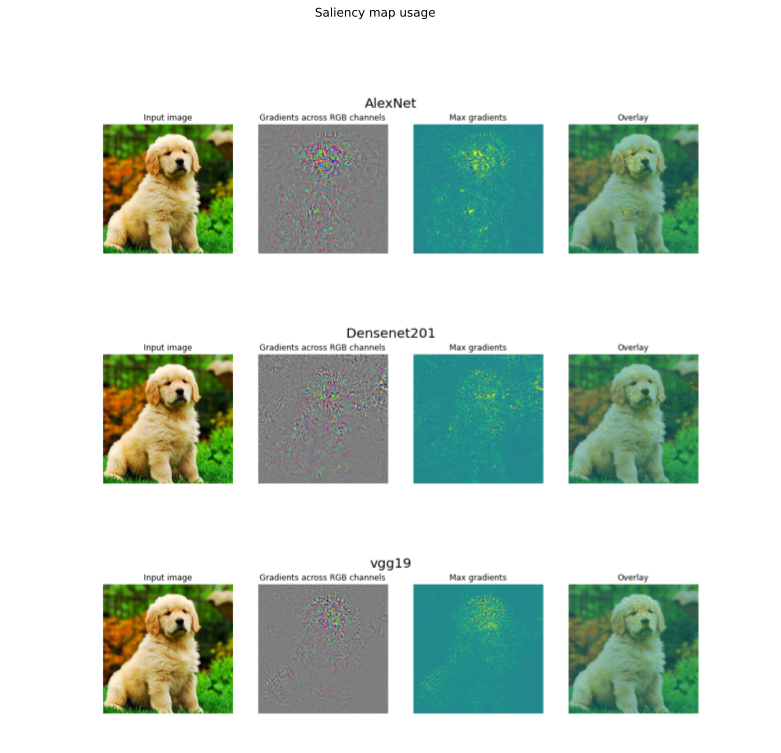

In [19]:
from cv2 import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
img1 = Image.open("/content/drive/MyDrive/results_saliency/AlexNet-retriver-saliencymap.png").convert('RGB')
img2 =  Image.open("/content/drive/MyDrive/results_saliency/Densenet201-retriver-saliencymap.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_saliency/vgg19-retriver-saliencymap.png").convert('RGB')

fig, axs = plt.subplots(3)
fig.patch.set_visible(False)

fig.suptitle("Saliency map usage")
fig.set_size_inches(17, 12)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

plt.show()

**◾Пример работы Grad-Cam (на последнем слое каждой сети)**

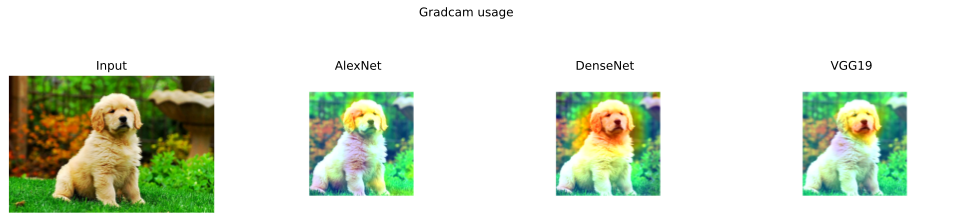

In [21]:
img1 = Image.open("/content/retriver.jpg").convert('RGB')

img2 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-11-golden_retriever.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_gradcam/DenseNet-gradcam-golden_retriever.png").convert('RGB')
img4 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-36-golden_retriever.png").convert('RGB')


fig, axs = plt.subplots(1,4)
fig.patch.set_visible(False)
fig.set_size_inches(17, 4)

fig.suptitle("Gradcam usage")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')


axs[0].set_title('Input')
axs[0].imshow(img1)

axs[1].set_title('AlexNet')
axs[1].imshow(img2)

axs[2].set_title("DenseNet")
axs[2].imshow(img3)

axs[3].set_title('VGG19')
axs[3].imshow(img4)

plt.show()


**◾Пример работы Occlusion Sensitivity (с разным размером патчей)**

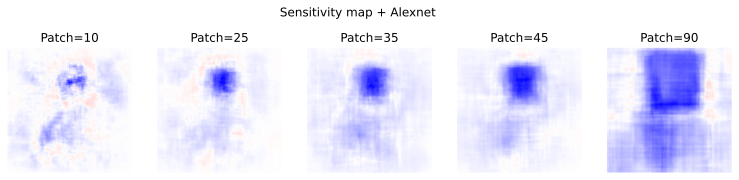

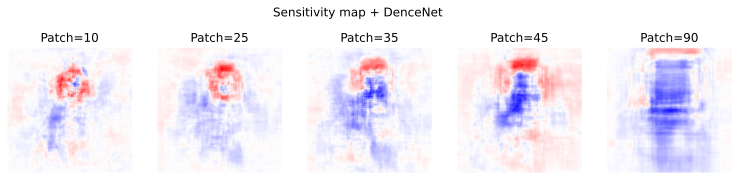

In [22]:
fig, axs = plt.subplots(1,5)
fig.set_size_inches(13, 3)


#Alexnet

img1 = Image.open("/content/drive/MyDrive/results_sensitivity/0-Alexnet-sensitivity-10-golden_retriever.png").convert('RGB')
img2 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-Alexnet-sensitivity-25-golden_retriever.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-Alexnet-sensitivity-35-golden_retriever.png").convert('RGB')
img4 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-Alexnet-sensitivity-45-golden_retriever.png").convert('RGB')
img5 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-Alexnet-sensitivity-90-golden_retriever.png").convert('RGB')

#Dencenet

img6 = Image.open("/content/drive/MyDrive/results_sensitivity/0-DenceNet-sensitivity-10-golden_retriever.png").convert('RGB')
img7 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-DenceNet-sensitivity-25-golden_retriever.png").convert('RGB')
img8 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-DenceNet-sensitivity-35-golden_retriever.png").convert('RGB')
img9 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-DenceNet-sensitivity-45-golden_retriever.png").convert('RGB')
img10 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-DenceNet-sensitivity-90-golden_retriever.png").convert('RGB')

fig.suptitle("Sensitivity map + Alexnet")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')


axs[0].set_title("Patch=10")
axs[1].set_title("Patch=25")
axs[2].set_title("Patch=35")
axs[3].set_title("Patch=45")
axs[4].set_title("Patch=90")


axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
axs[3].imshow(img4)
axs[4].imshow(img5)
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(13, 3)
fig.suptitle("Sensitivity map + DenceNet")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

axs[0].set_title("Patch=10")
axs[1].set_title("Patch=25")
axs[2].set_title("Patch=35")
axs[3].set_title("Patch=45")
axs[4].set_title("Patch=90")

axs[0].imshow(img6)
axs[1].imshow(img7)
axs[2].imshow(img8)
axs[3].imshow(img9)
axs[4].imshow(img10)
plt.show()

Как мы видим, данные графики помогают нам понять, что для данных моделей лучше брать Patch=35 или Patch=45, т.к. в остальных случаях модель либо основывается на слишкой маленькой, либо на слишком большой области изображения.

**◾Для интерпретации модели иногда нам важно понимать, как меняются построенные графики в зависимости от рассматриваемого слоя.**

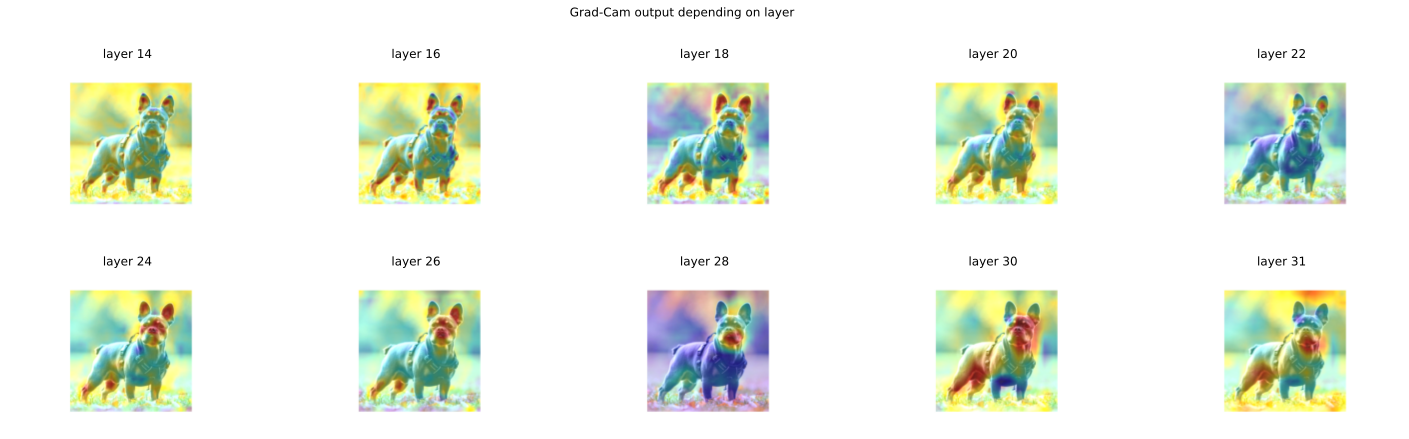

In [23]:
fig, axs = plt.subplots(2,5)
fig.set_size_inches(25, 7)

img1 = Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-14-French_bulldog.png").convert('RGB')
img2 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-16-French_bulldog.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-18-French_bulldog.png").convert('RGB')
img4 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-20-French_bulldog.png").convert('RGB')
img5 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-22-French_bulldog.png").convert('RGB')



img6 = Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-24-French_bulldog.png").convert('RGB')
img7 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-26-French_bulldog.png").convert('RGB')
img8 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-28-French_bulldog.png").convert('RGB')
img9 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-30-French_bulldog.png").convert('RGB')
img10 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-31-French_bulldog.png").convert('RGB')

fig.suptitle("Grad-Cam output depending on layer with vgg19")

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[0,3].axis('off')
axs[0,4].axis('off')


axs[0,0].set_title("layer 14")
axs[0,1].set_title("layer 16")
axs[0,2].set_title("layer 18")
axs[0,3].set_title("layer 20")
axs[0,4].set_title("layer 22")


axs[0,0].imshow(img1)
axs[0,1].imshow(img2)
axs[0,2].imshow(img3)
axs[0,3].imshow(img4)
axs[0,4].imshow(img5)


axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[1,3].axis('off')
axs[1,4].axis('off')

axs[1,0].set_title("layer 24")
axs[1,1].set_title("layer 26")
axs[1,2].set_title("layer 28")
axs[1,3].set_title("layer 30")
axs[1,4].set_title("layer 31")

axs[1,0].imshow(img6)
axs[1,1].imshow(img7)
axs[1,2].imshow(img8)
axs[1,3].imshow(img9)
axs[1,4].imshow(img10)
plt.show()

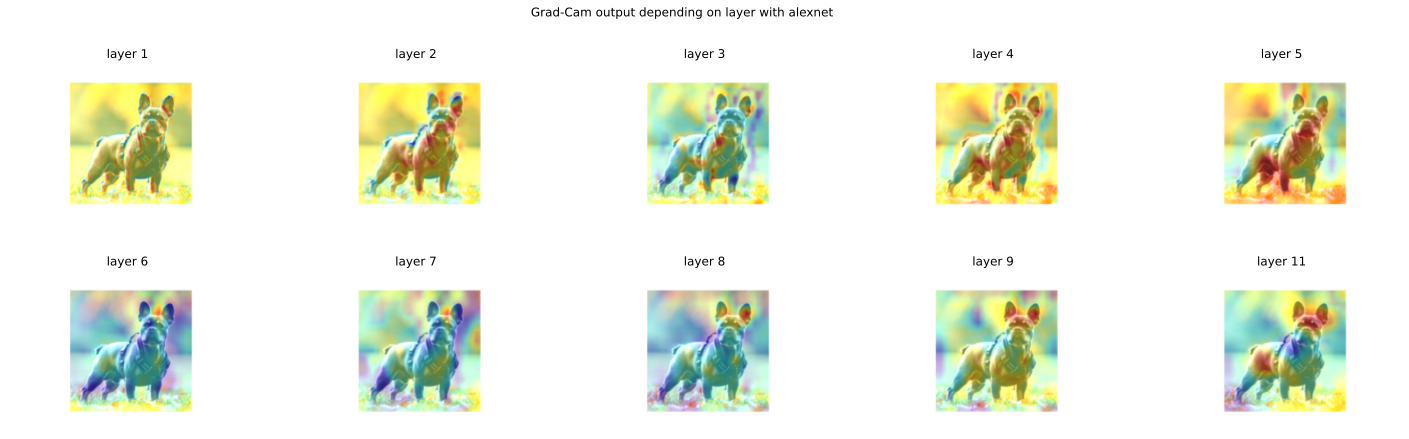

In [31]:
fig, axs = plt.subplots(2,5)
fig.set_size_inches(25, 7)

img1 = Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-1-French_bulldog.png").convert('RGB')
img2 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-2-French_bulldog.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-3-French_bulldog.png").convert('RGB')
img4 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-4-French_bulldog.png").convert('RGB')
img5 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-5-French_bulldog.png").convert('RGB')



img6 = Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-6-French_bulldog.png").convert('RGB')
img7 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-7-French_bulldog.png").convert('RGB')
img8 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-8-French_bulldog.png").convert('RGB')
img9 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-9-French_bulldog.png").convert('RGB')
img10 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-11-French_bulldog.png").convert('RGB')

fig.suptitle("Grad-Cam output depending on layer with alexnet")

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[0,3].axis('off')
axs[0,4].axis('off')


axs[0,0].set_title("layer 1")
axs[0,1].set_title("layer 2")
axs[0,2].set_title("layer 3")
axs[0,3].set_title("layer 4")
axs[0,4].set_title("layer 5")


axs[0,0].imshow(img1)
axs[0,1].imshow(img2)
axs[0,2].imshow(img3)
axs[0,3].imshow(img4)
axs[0,4].imshow(img5)


axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[1,3].axis('off')
axs[1,4].axis('off')

axs[1,0].set_title("layer 6")
axs[1,1].set_title("layer 7")
axs[1,2].set_title("layer 8")
axs[1,3].set_title("layer 9")
axs[1,4].set_title("layer 11")

axs[1,0].imshow(img6)
axs[1,1].imshow(img7)
axs[1,2].imshow(img8)
axs[1,3].imshow(img9)
axs[1,4].imshow(img10)
plt.show()

◾ Данные иллюстрации показывают, как менялось состояние модели от слоя к слою, какие области изображения считались наиболее важными на каждом этапе. Также, сравнивая иллюстрации, основанные на двух разных моделях, видим, что в течении их работы, на каждом слое (и в итоге) модели опирается на разные участки изображения. (Например, в самом конце vgg19 опирается на морду собаки, а alexnet на уши)

**◾Иллюстрация работы нейронных сетей может помочь нам понять, почему изображение может быть отнесено к разным классам (например, в случае нескольких объектов на изображении, передавая искомый класс, как параметр модели, мы можем видеть, что от этого сильно меняются итоговые построенные графики). Это помогает более четко понимать, как работает наша модель.**

Рассмотрим изображение, на котором четко видны два объекта, отсносящиеся к разным классам - полосатая кошка (класс tabby) и овчарка (класс German shepherd). Построим Grad-cam и Sensitivity map, чтобы понять, по каким частям изображения, сеть будет относить его к определенному классу. (в случае sensitivity map, чем синее область, тем больше сеть опирается на нее при определении данного класса)

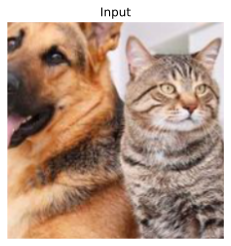

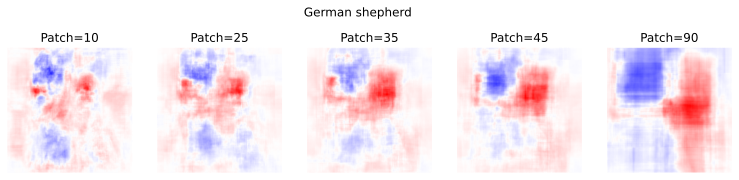

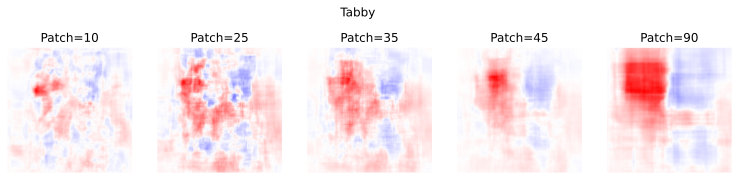

In [25]:
img0 = Image.open("/content/kot_pes.jpg").convert('RGB')

img0 = transforms.Resize(256)(img0)
img0 = transforms.CenterCrop(224)(img0)

plt.title("Input")
plt.axis("off")
plt.imshow(img0)
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(13, 3)



img1 = Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-10-German_shepherd.png").convert('RGB')
img2 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-25-German_shepherd.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-35-German_shepherd.png").convert('RGB')
img4 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-45-German_shepherd.png").convert('RGB')
img5 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-90-German_shepherd.png").convert('RGB')


img6 = Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-10-tabby.png").convert('RGB')
img7 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-25-tabby.png").convert('RGB')
img8 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-35-tabby.png").convert('RGB')
img9 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-45-tabby.png").convert('RGB')
img10 =  Image.open("/content/drive/MyDrive/results_sensitivity/0-vgg19-sensitivity-90-tabby.png").convert('RGB')

fig.suptitle("German shepherd")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')


axs[0].set_title("Patch=10")
axs[1].set_title("Patch=25")
axs[2].set_title("Patch=35")
axs[3].set_title("Patch=45")
axs[4].set_title("Patch=90")


axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
axs[3].imshow(img4)
axs[4].imshow(img5)
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(13, 3)
fig.suptitle("Tabby")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

axs[0].set_title("Patch=10")
axs[1].set_title("Patch=25")
axs[2].set_title("Patch=35")
axs[3].set_title("Patch=45")
axs[4].set_title("Patch=90")

axs[0].imshow(img6)
axs[1].imshow(img7)
axs[2].imshow(img8)
axs[3].imshow(img9)
axs[4].imshow(img10)
plt.show()

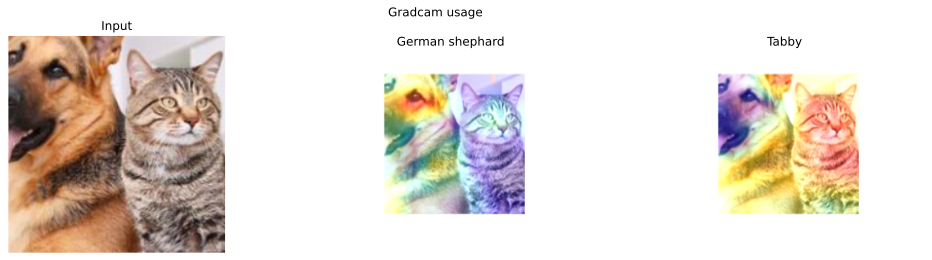

In [26]:
img1 = Image.open("/content/kot_pes.jpg").convert('RGB')
img1 = transforms.Resize(256)(img1)
img1 = transforms.CenterCrop(224)(img1)
img2 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-36-Old_English_sheepdog.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_gradcam/VGG19-gradcam-36-tabby.png").convert('RGB')


fig, axs = plt.subplots(1,3)
fig.patch.set_visible(False)
fig.set_size_inches(17, 4)

fig.suptitle("Gradcam usage")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')


axs[0].set_title('Input')
axs[0].imshow(img1)

axs[1].set_title('German shephard')
axs[1].imshow(img2)

axs[2].set_title("Tabby")
axs[2].imshow(img3)


plt.show()


◾ Из иллюстраций можно четко видеть, почему модель отнесла данную фотографию к одному из двух указанных выше классов. 

**◾ Также могут возникать ситуации, когда мы хотим посмотреть, какие классы модель выделяет как самые вероятные, и почему**

 Например, на данной илюстрации модель видит, как церковь (класс church), так и монастырь (класс monastery)

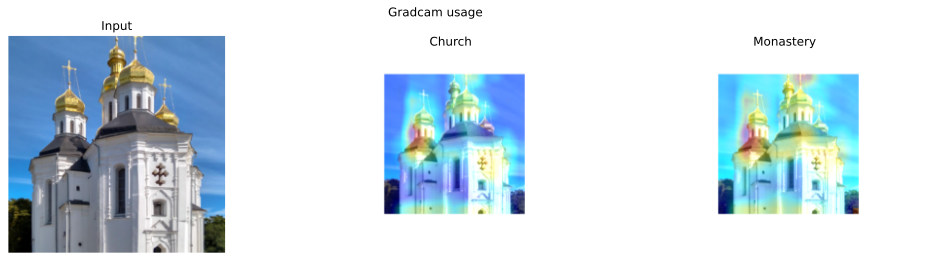

In [27]:
img1 = Image.open("/content/church.jpg").convert('RGB')
img1 = transforms.Resize(256)(img1)
img1 = transforms.CenterCrop(224)(img1)
img2 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-11-church.png").convert('RGB')
img3 =  Image.open("/content/drive/MyDrive/results_gradcam/AlexNet-gradcam-11-monastery.png").convert('RGB')


fig, axs = plt.subplots(1,3)
fig.patch.set_visible(False)
fig.set_size_inches(17, 4)

fig.suptitle("Gradcam usage")

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')


axs[0].set_title('Input')
axs[0].imshow(img1)

axs[1].set_title('Church')
axs[1].imshow(img2)

axs[2].set_title("Monastery")
axs[2].imshow(img3)


plt.show()


## **Вывод**

Как мы можем видеть, визуальное представление работы модели может помочь нам лучше понять почему мы получаем тот или иной результат, помогает сравнивать модели, а также подбирать оптимальные параметры (patch size).